## Generating Substructure (Goodwin and Whitworth, 2003)

Fractal distributions are generated by defining an ur-cube
with side 2, and placing an ur-parent at the centre of the
ur-cube. Next, the ur-cube is divided into N3
div equal subcubes,
and a child is placed at the centre of each sub-cube
(the first generation). Normally we use Ndiv = 2, in which
case there are 8 sub-cubes and 8 first-generation children.
The probability that a child matures to become a parent in
its own right is N(D−3)
div , where D is the fractal dimension; for
lower D, the probability that a child matures to become a parent
is lower. Children that do not mature are deleted, along
with the ur-parent. A little noise is then added to the positions
of the remaining children, to avoid an obviously gridded
structure, and they become the parents of the next generation,
each one spawning N3
div children (the second generation) at the
centres of N3
div equal-volume sub-sub-cubes, and each secondgeneration
child having a probability N(D−3)
div of maturing to become
a parent. This process is repeated recursively until there
is a suciently large generation that, even after pruning to impose
a spherical envelope of radius 1 within the ur-cube, there
are more children than the required number of stars. Children
are then culled randomly until the required number is left, and
the survivng children are identified with the stars of the cluster.

1. define a Cube with side 2 and place a parent in the centre.
2. Devide into $N^{3}_{div}$ (Usually $N_{div}=2$ ) and place a child in each of these.
3. the proability that a child becomes an adult is $N^{D-3}_{div}$, where D is the fractal dimension. (high D higher chance of maturity).
4. Children that di not mature are deleted along with the UR-parent
5. Noise (prehaps gaussian noise) is added to the Child postions (avoids grid structure).
6. These then become the next generation each spawning $N_{div}^{3}$ children.
7. process repeats untill we have a sufficient amount of stars.

In [183]:
import numpy as np
import matplotlib.pylab as plt
M_sol = 1.99E30
G = 6.67E-11
AU = 1.49E11
N = 1000
D = 0.5
A = B = C = 206264 #AU


In [184]:
def Genlen(n):
    return A*(1/2)**n , B*(1/2)**n, C*(1/2)**n

def gen_pos(parent,n):
    a,b,c = Genlen(n)
    one = np.array([[-(1/2)*b , -(1/2)*a , -(1/2)*c],
                    [-(1/2)*b , -(1/2)*a ,  (1/2)*c],
                    [-(1/2)*b ,  (1/2)*a , -(1/2)*c],
                    [ (1/2)*b , -(1/2)*a , -(1/2)*c],
                    [ (1/2)*b ,  (1/2)*a ,  (1/2)*c],
                    [ (1/2)*b ,  (1/2)*a , -(1/2)*c],
                    [ (1/2)*b , -(1/2)*a ,  (1/2)*c],
                    [-(1/2)*b ,  (1/2)*a ,  (1/2)*c]])
    noise = np.random.normal(-0.1,0.1, size=(8,3))*A
    new = np.subtract(one, parent) + noise
    return new

def prob_of_mature(D):
    return 2**(D-3)


def survial(children,vel,D):
    parent = []
    vel_sur = []
    v, mass = vel
    Mass = []
    for i in range(0,len(children)):
        rand = np.random.uniform(0,1)
        prob = prob_of_mature(D)
        if rand<= prob:
            parent+=[children[i]]
            vel_sur+=[v[i]] 
            Mass += [mass[i]]
    return np.array(parent), np.array(vel_sur), np.array(Mass)

def gen_vel(vp,x):
    vel = np.random.uniform(-1,1,size=(8,3))
    Mass = cust_dis(len(vel),0,20,Kroupa_IMF)
    X, Y, Z = x[:,0], x[:,1], x[:,2]
    PE_tot = 0
    for k in range(1,len(X)): 
             for j in range(0,k-1):
                R_res = np.sqrt((X[k]-X[j])**2 + (Y[k]-Y[j])**2 + (Z[k]-Z[j])**2)
                PE_tot += (G*Mass[k]*M_sol**2*Mass[j])/(R_res*AU)     
    Ek_tot = 0
    for i in range(0,len(X)):
        Ek_tot += 0.5 * Mass[i]*M_sol* (np.sqrt(vel[i,0]**2 + vel[i,1]**2 + vel[i,2]**2))**2
    a = np.sqrt((0.5*PE_tot)/(Ek_tot)) 
    vel = a*vel - vp                            
    return vel, Mass


In [185]:
def cust_dis(N,x0,x1,imf,nControl=10**6):
    sample = []
    nLoop  = 0
    while len(sample)<N and nLoop<nControl:
        x = np.random.uniform(x0,x1)     
        prop = imf(x)
        assert prop>=0
        if np.random.uniform(0,1) <= prop: #26.67 is max probability 
            sample += [x]
        nLoop+= 1
    return np.array(sample)
    
def Kroupa_IMF(m):
    alpha = 0
    if m > 0 and m < 0.08:
        alpha = 0.3
    if m > 0.08 and m < 0.5:
        alpha = 1.3
    if m > 0.5:
        alpha = 2.3
    return m**(-alpha)

In [186]:
gen_number = 0
n = 0
while n < N:
    if n == 0:
        parent = np.zeros(1)
        vel_p = np.array([0,0,0])
        Mass = np.array([0])
    for i in range(0,len(parent)):
        vp = vel_p[i]
        x = gen_pos(parent[i],gen_number)
        vel = gen_vel(vp,x)
        if i == 0 and n == 0:
            par, vel_p, Mass_new = survial(x,vel,D)

        else:
            new, vel_n, Mass_new = survial(x,vel,D)
            if len(new) == 0:
                break
            else:
                par = np.vstack((par,new))
                vel_p = np.vstack((vel_p,vel_n))
                Mass = np.hstack((Mass,Mass_new))
    parent = par
    n = len(parent)
    gen_number += 1

print(gen_number)
print(n)
print(vel_p)
print(len(Mass))
print(len(parent))
#print(Mass[n]*Mass[n])
PE_tot = 0
        #try:
for k in range(1,len(Mass)): #note since 0 is the begining of the index.
    for j in range(0,k-1):
            R_res = np.sqrt((parent[k,0]-parent[j,0])**2 + (parent[k,1]-parent[j,1])**2 + (parent[k,2]-parent[j,2])**2)
            PE_tot += (G * Mass[j]*M_sol**2*Mass[k])/(R_res*AU) 
        
       
        
print('Potential Energy',PE_tot)
        # Calculating Kinetic Energy!
Ek_tot = 0
q = 0.5
print('Median Mass', np.median(Mass))
for i in range(0,len(Mass)):
    Ek_tot += 0.5 * Mass[i] *M_sol* (np.sqrt(vel_p[i,0]**2 + vel_p[i,1]**2 + vel_p[i,2]**2))**2
print('Total kineitc energy (with out added factor): ',Ek_tot)
a = np.sqrt((q*PE_tot)/(Ek_tot))
print('Velocity factor: ',a)
v = vel_p*a
print('mean v (m/s):',np.mean(v))
print('median v (m/s):',np.median(v))
print('std v (m/s):',np.std(v))
print('min v (m/s):',np.min(v))
print('max v (m/s):',np.max(v))

158
1002
[[  71.60069249  -57.45998575  -38.76289289]
 [ -39.83223518   69.19960318  -58.14256672]
 [-145.54629313   47.09720155   -7.96330998]
 ...
 [ 368.57834254 -726.59288316 -330.12540179]
 [-262.38801758  375.99023839  225.91395711]
 [-228.73976803 -761.25503234 -573.74431865]]
1001
1002
Potential Energy 1.4136457171186171e+40
Median Mass 0.9197841343522306
Total kineitc energy (with out added factor):  1.6410505823413479e+38
Velocity factor:  6.562877670536087
mean v (m/s): -14.978613486945392
median v (m/s): -11.079966679875312
std v (m/s): 1273.2805421328908
min v (m/s): -4996.023653315906
max v (m/s): 4146.459756010487


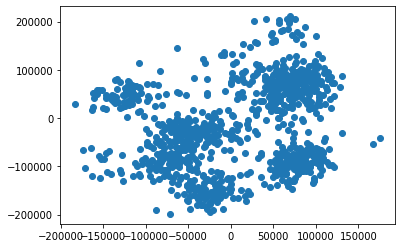

In [187]:
plt.scatter(parent[:,0],parent[:,1])
plt.show()

No handles with labels found to put in legend.


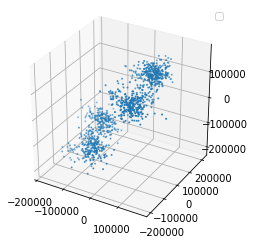

In [188]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(parent[:,0],parent[:,1],parent[:,2],s = 1)      
ax.set_box_aspect([1,1,1]) #figsize changes to appropriate dimentions
plt.legend()
plt.show()

In [189]:
N = 10

a = 1 #for simplicity atm
b = 1
c = 1


# cube with 2 sides a and b, centerd on 0,0
D = 2
x_0 = gen_pos([0,0,0],0,0)
x_0_sur = []
for i in range(0,len(x_0[:,0])):
    rand = np.random.uniform(0,1)
    prob = prob_of_mature(D)
    if rand <= prob:
        x_0_sur += [x_0[i]]
x_0_cull = np.array(x_0_sur)  
print(x_0_cull)
parent = x_0_cull
new_parent = np.empty(1)
for i in range(0,len(parent)):
    child = gen_pos(parent[i],1,guassian_Noise)
    child_sur = []
    for j in range(0,len(child)):
        rand = np.random.uniform(0,1)
        prob = prob_of_mature(D)
        if rand <= prob:
            child_sur += [child[i]]
    new_parent[i] = np.array(child_sur)
    #print(parent)
print(new_parent)

"""
for i in range(0,len(x_0_cull[:,0])):
    new = gen_pos(x_0_cull[i],1,guassian_Noise)
    new_sur = []
    for i in range(0,len(new[:,0])):
        rand = np.random.uniform(0,1)
        prob = prob_of_mature(D)
        if rand <= prob:
            new_sur += [new[i]] 
    new_gen += [new_sur]
    parent = np.array(new_gen)
print(new_gen)
"""

TypeError: gen_pos() takes 2 positional arguments but 3 were given

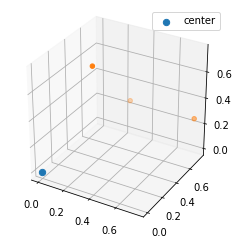

In [64]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(0,0,0,label='center',s=40)
ax.scatter(x12[:,0],x12[:,1],x12[:,2])      
ax.set_box_aspect([1,1,1]) #figsize changes to appropriate dimentions

plt.legend()
plt.show()

In [162]:
noise = np.random.normal(0,0.1, size=(8,3))
print(noise)

[[-0.11022739 -0.14361132  0.00894382]
 [ 0.08531122  0.13270465 -0.26043439]
 [ 0.09540568 -0.01799607  0.04051672]
 [ 0.06748257  0.02055169 -0.10677902]
 [ 0.06876079  0.01440693  0.08517275]
 [ 0.06572764  0.13811289 -0.08990744]
 [-0.02647371  0.00985819 -0.06331739]
 [ 0.08749189 -0.10255593 -0.2455935 ]]
